# 🔧 Environment Setup

Install core libraries for fine-tuning BioClinical ModernBERT on a symptom→disease classification task.

**Main Packages**
- `transformers` – model + Trainer utilities
- `datasets` – dataset loading & mapping
- `torch` – deep learning backend
- `scikit-learn` – metrics & evaluation
- `optuna` – hyperparameter optimization
- `evaluate` – standardized metric interface
- `wandb` – experiment tracking (optional)
- `pandas`, `numpy` – data manipulation
- `matplotlib`, `seaborn` – plotting

Run the install cell below once (reuse cached env afterwards). Keep dependencies minimal to reduce startup time.

In [1]:
%pip install transformers datasets torch scikit-learn kagglehub pandas numpy keras matplotlib seaborn nbformat optuna evaluate wandb wandb[core]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qltpagsuguiron (qltpagsuguiron-technological-institute-of-the-philippines) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 📊 Dataset Preprocessing

Prepare the symptom→disease dataset for supervised classification.

**Steps**
1. Load filtered English dataset from Hugging Face.
2. Keep only `text` (symptom description) + `label` (disease).
3. Build `label2id` / `id2label` mappings; convert labels to integer `labels` field.
4. Split: 80% train / 10% validation / 10% test (seed=42 for reproducibility).

Outputs:
- Clean splits stored in a Python dict `dataset` with keys: `train`, `validation`, `test`.
- Consistent integer label space used throughout training & evaluation.

In [3]:
from datasets import load_dataset
from transformers import set_seed

set_seed(42)

full_dataset = load_dataset("notlath/eng_dataset")

def preprocess_labels(example):
    # Use the correct column names from the dataset
    return {
        'text': example['text'],      # Use the actual 'text' column
        'label': example['label']     # Use the actual 'label' column
    }

# Apply preprocessing
processed_dataset = full_dataset['train'].map(preprocess_labels)

# Get unique labels and create mappings
unique_labels = list(set(processed_dataset['label']))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

# Convert labels to integers
def convert_labels_to_ids(example):
    return {
        'text': example['text'],
        'labels': label2id[example['label']]  # Convert to integer and rename to 'labels'
    }

processed_dataset = processed_dataset.map(convert_labels_to_ids, remove_columns=['label'])

# Split the dataset into train (75%), validation (15%), and test (15%)
train_test_split = processed_dataset.train_test_split(test_size=0.3, seed=42) # Split off 30% for test+validation
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42) # Split the 30% equally

dataset = {
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
}

print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/473k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'labels'],
    num_rows: 2100
}), 'validation': Dataset({
    features: ['text', 'labels'],
    num_rows: 450
}), 'test': Dataset({
    features: ['text', 'labels'],
    num_rows: 450
})}


In [4]:
print("Original dataset columns:")
print(full_dataset['train'].column_names)
print("\nFirst few examples from original dataset:")
for i in range(3):
    print(f"Example {i}: {full_dataset['train'][i]}")

Original dataset columns:
['label', 'text']

First few examples from original dataset:
Example 0: {'label': 'Dengue', 'text': "A 100.2°F fever began two days ago, bringing with it a mild headache and some stiffness in my elbows. I'm feeling a bit run down with some mild fatigue, and my appetite has slightly decreased, but there are no other significant symptoms."}
Example 1: {'label': 'Dengue', 'text': "A 100.3°F fever has been present for the last two days, along with a mild, dull headache. My joints are a little stiff, and I've developed a very slight, dry cough. Overall, I feel unwell and a bit fatigued, and my appetite has slightly decreased, but it's manageable."}
Example 2: {'label': 'Dengue', 'text': "A 100.5°F fever and a mild headache started two days ago. My knees feel a little sore, but my movement is fine. I'm also a bit tired and my appetite is not what it usually is, but the symptoms are mild enough that I can get through most of my daily tasks."}


In [5]:
print("Dataset structure:")
print(dataset)
print("\nSample data from train:")
print(dataset["train"][0])
print(f"Type of text field: {type(dataset['train'][0]['text'])}")
print(f"Text content: {dataset['train'][0]['text']}")

Dataset structure:
{'train': Dataset({
    features: ['text', 'labels'],
    num_rows: 2100
}), 'validation': Dataset({
    features: ['text', 'labels'],
    num_rows: 450
}), 'test': Dataset({
    features: ['text', 'labels'],
    num_rows: 450
})}

Sample data from train:
{'text': 'What I thought was just the flu started three days ago with a 101.3°F fever. Yesterday, however, I began feeling an excruciating pain deep behind my eyes every time I turn my head. My knees also started to grind painfully when I go down the stairs. Just this morning, I found red speckles scattered over my lower back that were not there before I showered.', 'labels': 0}
Type of text field: <class 'str'>
Text content: What I thought was just the flu started three days ago with a 101.3°F fever. Yesterday, however, I began feeling an excruciating pain deep behind my eyes every time I turn my head. My knees also started to grind painfully when I go down the stairs. Just this morning, I found red speckles scatte

# 🤖 Model Setup & Tokenization

**Model**: `thomas-sounack/BioClinical-ModernBERT-base` (domain‑adapted BERT variant for clinical/biomedical text).

**Tokenization**
- Apply tokenizer to all splits with truncation + dynamic padding.
- Remove raw `text` after encoding; retain `input_ids`, `attention_mask`, `labels`.

**Goal**: Produce uniform, batched tensors ready for `AutoModelForSequenceClassification`.

Result: `tokenized_dataset` mirrors original splits with encoded features.

In [6]:
from transformers import AutoTokenizer

model_id = "thomas-sounack/BioClinical-ModernBERT-base"
# Remove conflicting parameters from tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
    )

# Apply tokenize to each dataset split
tokenized_dataset = {}
for split, data in dataset.items():
    tokenized_dataset[split] = data.map(tokenize, batched=True, remove_columns=["text"])

print(tokenized_dataset)
print("Features:", tokenized_dataset["train"].features.keys())

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 2100
}), 'validation': Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 450
}), 'test': Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 450
})}
Features: dict_keys(['labels', 'input_ids', 'attention_mask'])


In [7]:
from transformers import AutoModelForSequenceClassification

unique_labels = tokenized_dataset["train"].unique("labels")
num_labels = len(unique_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 🔍 Hyperparameter Optimization

Optimize training for validation accuracy using Optuna (TPE sampler, persistent SQLite storage).

**Objective**: Maximize `eval_accuracy`.

**Fixed Regularization**: All dropout variants set to 0.1.

**Search Space**
- Learning rate: log-uniform [2e-5, 8e-5]
- Train batch size: {64, 128}
- Weight decay: uniform [0.15, 0.35]

**Process**
1. `model_init` supplies fresh model each trial (ensures comparable starts).
2. Trainer runs one configuration → records metrics.
3. Best trial exported to `hyperparameters.txt` for reuse.

Result: `best_run` object with chosen LR, batch size, weight decay.

In [8]:
%pip install optuna

In [9]:
import optuna
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

# Define persistent storage
storage = RDBStorage("sqlite:///optuna_trials.db")

study = optuna.create_study(
    study_name="transformers_optuna_study", direction="maximize", storage=storage, load_if_exists=True, sampler=sampler
)

[I 2025-11-05 03:50:26,549] A new study created in RDB with name: transformers_optuna_study


In [10]:
%pip install evaluate

In [11]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions.argmax(axis=-1)
    labels = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=labels)

def compute_objective(metrics):
    return metrics["eval_accuracy"]

In [12]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification, AutoTokenizer

model_id = "thomas-sounack/BioClinical-ModernBERT-base"
# Define tokenizer here
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Define data_collator here
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define num_labels, label2id, and id2label here
unique_labels = dataset["train"].unique("labels")
num_labels = len(unique_labels)
# Assuming label2id and id2label were created in a previous successful cell.
# If not, they would need to be recreated here based on unique_labels.
# Based on the provided notebook state, label2id and id2label are available.

training_args = TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    seed=42,
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="wandb",
    logging_dir="./logs",
    run_name="transformers_optuna_study",
)

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 8e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.15, 0.35),
    }

def model_init(trial=None):
    return AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        label2id=label2id,
        id2label=id2label,
        attention_dropout=0.1,      # ✅ Correct parameter name
        mlp_dropout=0.1,             # ✅ Correct parameter name (not hidden_dropout)
        embedding_dropout=0.1,       # ✅ Optional but recommended
        classifier_dropout=0.1,      # ✅ Keep this
    )

trainer = Trainer(
    # Pass model_init instead of model
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Flattening the indices:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=8,  # 🔥 INCREASED from 5 to 8
    compute_objective=compute_objective,
    study_name="transformers_optuna_study",
    storage="sqlite:///optuna_trials.db",
    load_if_exists=True,
)

print(best_run)

[I 2025-11-05 03:50:42,738] Using an existing study with name 'transformers_optuna_study' instead of creating a new one.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: qltpagsuguiron (qltpagsuguiron-technological-institute-of-the-philippines) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W1105 03:51:14.679000 717 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy
1,0.675000,0.412622,0.906667
2,0.197200,0.219795,0.942222
3,0.100700,0.097642,0.973333
4,0.041600,0.084944,0.973333
5,0.027900,0.067595,0.968889


[I 2025-11-05 04:05:27,593] Trial 0 finished with value: 0.9688888888888889 and parameters: {'learning_rate': 3.840059113469352e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.27928595142096013}. Best is trial 0 with value: 0.9688888888888889.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅███
eval/loss,█▄▂▁▁
eval/runtime,█▁▁▁▁
eval/samples_per_second,▁████
eval/steps_per_second,▁████
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,▂▁█▁▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.96889


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684400,0.302273,0.928889
2,0.188000,0.135759,0.960000
3,0.068800,0.066953,0.980000
4,0.044700,0.057734,0.975556
5,0.020900,0.052560,0.977778


[I 2025-11-05 04:19:25,359] Trial 1 finished with value: 0.9777777777777777 and parameters: {'learning_rate': 5.924237645676442e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.2539225465884592}. Best is trial 1 with value: 0.9777777777777777.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅█▇█
eval/loss,█▃▁▁▁
eval/runtime,▁▁█▅▁
eval/samples_per_second,██▁▄█
eval/steps_per_second,██▁▄█
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,██▁▁▁
train/learning_rate,█▆▄▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.97778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.665700,0.261432,0.922222
2,0.162300,0.097309,0.960000
3,0.080100,0.074002,0.968889
4,0.039800,0.039922,0.977778
5,0.024100,0.042228,0.980000


[I 2025-11-05 04:34:33,674] Trial 2 finished with value: 0.98 and parameters: {'learning_rate': 6.873815641553449e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.1968361171791204}. Best is trial 2 with value: 0.98.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇██
eval/loss,█▃▂▁▁
eval/runtime,▅▅▅█▁
eval/samples_per_second,▄▄▄▁█
eval/steps_per_second,▄▄▄▁█
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,▂█▅▁▁
train/learning_rate,█▆▄▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.98


Epoch,Training Loss,Validation Loss,Accuracy
1,0.986200,0.471580,0.871111
2,0.329900,0.323267,0.906667
3,0.210500,0.224778,0.924444
4,0.154500,0.201084,0.935556
5,0.116200,0.184453,0.928889


[I 2025-11-05 04:50:36,402] Trial 3 finished with value: 0.9288888888888889 and parameters: {'learning_rate': 2.4789553403926196e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2978640847294709}. Best is trial 2 with value: 0.98.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇█▇
eval/loss,█▄▂▁▁
eval/runtime,▁▇▃▆█
eval/samples_per_second,█▂▆▃▁
eval/steps_per_second,█▂▆▃▁
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,▆▂█▃▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.92889


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804100,0.446307,0.900000
2,0.277100,0.224253,0.922222
3,0.154800,0.159442,0.940000
4,0.094800,0.106870,0.968889
5,0.063500,0.118331,0.957778


[I 2025-11-05 05:07:08,270] Trial 4 finished with value: 0.9577777777777777 and parameters: {'learning_rate': 2.3368204897525952e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.30269396565002105}. Best is trial 2 with value: 0.98.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▃▅█▇
eval/loss,█▃▂▁▁
eval/runtime,█▂▁▁▃
eval/samples_per_second,▁▇██▆
eval/steps_per_second,▁▇██▆
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,█▃▂▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.95778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.636300,0.363014,0.926667
2,0.164300,0.146265,0.955556
3,0.077300,0.064883,0.975556
4,0.033300,0.063468,0.982222
5,0.018500,0.055545,0.984444


[I 2025-11-05 05:23:36,589] Trial 5 finished with value: 0.9844444444444445 and parameters: {'learning_rate': 7.269803255258328e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.1659889040345907}. Best is trial 5 with value: 0.9844444444444445.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▅▇██
eval/loss,█▃▁▁▁
eval/runtime,▇▂▁█▄
eval/samples_per_second,▂▇█▁▅
eval/steps_per_second,▂▇█▁▅
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,▁▁█▁▁
train/learning_rate,█▆▄▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.98444


Epoch,Training Loss,Validation Loss,Accuracy
1,1.064000,0.466562,0.871111


[I 2025-11-05 05:25:24,551] Trial 6 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.87111


Epoch,Training Loss,Validation Loss,Accuracy
1,1.080200,0.467882,0.871111


[I 2025-11-05 05:27:09,621] Trial 7 pruned. 


BestRun(run_id='5', objective=0.9844444444444445, hyperparameters={'learning_rate': 7.269803255258328e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.1659889040345907}, run_summary=None)


In [14]:
from pprint import pprint

# Write the best hyperparameters to a file
with open("hyperparameters.txt", "w") as f:
    for key, value in best_run.hyperparameters.items():
        f.write(f"{key}: {value}\n")

print("Best hyperparameters saved to hyperparameters.txt")
print("\nBest Hyperparameters:")
pprint(best_run.hyperparameters)

Best hyperparameters saved to hyperparameters.txt

Best Hyperparameters:
{'learning_rate': 7.269803255258328e-05,
 'per_device_train_batch_size': 16,
 'weight_decay': 0.1659889040345907}


# 🎯 Final Model Training

Train with best hyperparameters and enhanced stability settings.

**Core Settings**
- Epochs: 10 (extended training)
- Batch size (train): 64 | (eval): 16
- Learning rate: Optuna-selected (6.43e-5) + cosine schedule + 10% warmup
- Weight decay: 0.307
- Label smoothing: 0.1 | Gradient clipping: 0.1
- Dropout: attention / mlp / embedding / classifier = 0.1

**Trainer Features**
- `load_best_model_at_end` + accuracy selection
- Epoch-level eval + checkpoint pruning (`save_total_limit=2`)
- Weights & Biases tracking
- Hub-ready (`hub_model_id` set)

Outcome: `extended_final_model` directory containing the best fine‑tuned weights.

In [15]:
import shutil
import os

folder_path = "./results"
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Removed folder: {folder_path}")
else:
    print(f"Folder not found: {folder_path}")

Removed folder: ./results


In [16]:
# Use the ACTUAL best hyperparameters from Optuna optimization
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding

model_id = "thomas-sounack/BioClinical-ModernBERT-base"

# Use the actual best hyperparameters from Optuna search
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    attention_dropout=0.1,      # ✅ Correct parameter name
    mlp_dropout=0.1,             # ✅ Correct parameter name (not hidden_dropout)
    embedding_dropout=0.1,       # ✅ Optional but recommended
    classifier_dropout=0.1,      # ✅ Keep this
)

# Calculate training steps for warmup using optimal batch size
steps_per_epoch = len(tokenized_dataset["train"]) // best_run.hyperparameters["per_device_train_batch_size"]
total_steps = steps_per_epoch * 10
warmup_steps = int(total_steps * 0.1)

training_args = TrainingArguments(
    output_dir="./extended_final_model",

    # 🎯 OPTUNA-OPTIMIZED HYPERPARAMETERS
    per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],  # 128 (from Optuna)
    learning_rate=best_run.hyperparameters["learning_rate"],                              # 4.76e-05 (from Optuna)
    weight_decay=best_run.hyperparameters["weight_decay"],                                # 0.258 (from Optuna)

    # 🚀 TRAINING CONFIGURATION
    per_device_eval_batch_size=16,          # Evaluation batch size
    num_train_epochs=8,                    # Extended training (doubled from 5)

    # 📈 OPTIMIZATION ENHANCEMENTS
    warmup_steps=warmup_steps,              # 10% of total steps for warmup
    lr_scheduler_type="cosine",             # Cosine learning rate decay
    label_smoothing_factor=0.1,             # Label smoothing for regularization
    max_grad_norm=1.0,                      # Gradient clipping for stability

    # 💾 CHECKPOINT & EVALUATION
    eval_strategy="epoch",                   # Evaluate every epoch
    save_strategy="epoch",                   # Save every epoch
    save_total_limit=2,                     # Keep only 2 best checkpoints
    load_best_model_at_end=True,            # Load best model after training
    metric_for_best_model="eval_accuracy",   # Use accuracy as selection metric
    greater_is_better=True,                 # Higher accuracy is better

    # 📊 LOGGING & TRACKING
    logging_strategy="epoch",                # Log every epoch
    report_to="wandb",                      # Report to Weights & Biases
    run_name="final_training_optimized_hyperparams",  # Updated run name

    # 🌐 HUGGING FACE INTEGRATION
    hub_model_id="rchrdwllm/BioClinical-ModernBERT-base-Symptom2Disease_WITHOUT-DROPOUT-42",

    # 🔧 REPRODUCIBILITY
    seed=42,                                # Fixed seed for reproducibility
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 🎯 START TRAINING
trainer.train()

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.215900,0.773728,0.868889
2,0.604200,0.493106,0.975556
3,0.481400,0.463756,0.980000
4,0.448400,0.459497,0.982222
5,0.436900,0.453335,0.982222
6,0.429000,0.456020,0.982222
7,0.424800,0.460735,0.984444
8,0.424900,0.460993,0.982222


TrainOutput(global_step=1056, training_loss=0.5581911224307436, metrics={'train_runtime': 1220.7631, 'train_samples_per_second': 13.762, 'train_steps_per_second': 0.865, 'total_flos': 2225103949756800.0, 'train_loss': 0.5581911224307436, 'epoch': 8.0})

# 🚀 Deployment to Hugging Face Hub

Publish the fine‑tuned model for reuse and transparency.

**Repo**: `notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT`

**Steps**
1. Authenticate with a secure Hugging Face token (never hard‑code in shared notebooks; use env var or input prompt).
2. Call `trainer.push_to_hub()` (auto‑uploads model + tokenizer + config).
3. If that fails, manually load from `final_model_train/` and push model + tokenizer.
4. Verify `config.json` lists all dropout params (attention, mlp, embedding, classifier = 0.1).

**Post‑Upload Checklist**
- Model card updated (add task, dataset citation, metrics, limitations).
- License + intended use documented.
- Example inference snippet works via `pipeline()`.

Outcome: Public, reproducible artifact ready for downstream evaluation.

In [22]:
from huggingface_hub import login

# Paste your token here - Get from https://huggingface.co/settings/tokens
token = "YOUR_HF_TOKEN_HERE"  # Replace with your actual token
login(token=token)

# Verify it worked
from huggingface_hub import whoami
try:
    user = whoami()
    print(f"✅ Logged in as: {user['name']}")
except Exception as e:
    print(f"❌ Login failed: {e}")

# Push model using trainer.push_to_hub() - this ensures the trained model is pushed
repo_name = "notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42"

print("🚀 Pushing model to Hugging Face...")
try:
    # Method 1: Use trainer.push_to_hub() (recommended)
    trainer.push_to_hub(repo_name, token=token)
    print(f"✅ Successfully pushed model using trainer.push_to_hub() to {repo_name}")
except Exception as e:
    print(f"❌ trainer.push_to_hub() failed: {e}")
    print("🔄 Trying alternative method...")

    # Method 2: Alternative - push model and tokenizer separately from the saved directory
    try:
        from transformers import AutoModelForSequenceClassification, AutoTokenizer

        # Load the saved model with correct dropout config
        saved_model = AutoModelForSequenceClassification.from_pretrained("./final_model_train")
        saved_tokenizer = AutoTokenizer.from_pretrained("./final_model_train")

        # Push the saved model and tokenizer
        saved_model.push_to_hub(repo_name, token=token)
        saved_tokenizer.push_to_hub(repo_name, token=token)
        print(f"✅ Successfully pushed model using alternative method to {repo_name}")

    except Exception as e2:
        print(f"❌ Alternative method also failed: {e2}")

print("\n📋 Verify your model config includes all dropout parameters:")
print("Visit: https://huggingface.co/" + repo_name + "/blob/main/config.json")

# Load the model config to get actual dropout values
from transformers import AutoConfig
try:
    # Try to load from the pushed model on HuggingFace
    config = AutoConfig.from_pretrained(repo_name)
    print("✅ Loaded config from HuggingFace Hub")
except:
    # Fallback to local model if HuggingFace fails
    config = AutoConfig.from_pretrained("./final_model_train")
    print("✅ Loaded config from local model")

print("Actual dropout parameters:")
print(f"- attention_dropout: {getattr(config, 'attention_dropout', 'Not found')}")
print(f"- mlp_dropout: {getattr(config, 'mlp_dropout', 'Not found')}")
print(f"- embedding_dropout: {getattr(config, 'embedding_dropout', 'Not found')}")
print(f"- classifier_dropout: {getattr(config, 'classifier_dropout', 'Not found')}")

# Also show hidden_dropout_prob if available (common BERT parameter)
if hasattr(config, 'hidden_dropout_prob'):
    print(f"- hidden_dropout_prob: {config.hidden_dropout_prob}")

✅ Logged in as: notlath
🚀 Pushing model to Hugging Face...
❌ trainer.push_to_hub() failed: (Request ID: Root=1-690ae8d3-468504e53f2b31364092b60a;8a5040f2-3ce4-4c4e-bcec-5625f168b816)

403 Forbidden: You have read access but not the required permissions for this operation.
Cannot access content at: https://huggingface.co/rchrdwllm/BioClinical-ModernBERT-base-Symptom2Disease_WITHOUT-DROPOUT-42.git/info/lfs/objects/batch.
Make sure your token has the correct permissions.
🔄 Trying alternative method...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ss59g3t/model.safetensors:   0%|          |  553kB /  598MB            

✅ Successfully pushed model using alternative method to notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42

📋 Verify your model config includes all dropout parameters:
Visit: https://huggingface.co/notlath/BioClinical-ModernBERT-base-Symptom2Disease_WITH-DROPOUT-42/blob/main/config.json


config.json: 0.00B [00:00, ?B/s]

✅ Loaded config from HuggingFace Hub
Actual dropout parameters:
- attention_dropout: 0.1
- mlp_dropout: 0.1
- embedding_dropout: 0.1
- classifier_dropout: 0.1


# 📈 Model Evaluation & Performance Analysis

Assess generalization and practical usefulness.

**Test Set**
- Run final model on held‑out `test` split → accuracy + per‑class metrics.

**Metrics**
- Precision / Recall / F1 (macro & per class)
- Confusion matrix for error patterns.

**Cross‑Validation**
- 5‑fold CV on training data reinitializing model per fold → average accuracy & variance.

**Practical Checks**
- Inference on handcrafted clinical symptom narratives.
- Save artifacts (`final_model_train`) for deployment & reproducibility.

Outcome: Quantitative metrics + qualitative sanity checks supporting reliability.

In [18]:
# Save the trained model and tokenizer explicitly
trainer.save_model("./final_model_train")
tokenizer.save_pretrained("./final_model_train")

('./final_model_train/tokenizer_config.json',
 './final_model_train/special_tokens_map.json',
 './final_model_train/tokenizer.json')

In [19]:
from sklearn.metrics import classification_report
import numpy as np

test_split = tokenized_dataset["test"]
predictions, labels, metrics = trainer.predict(test_split)
y_pred = np.argmax(predictions, axis=1)
y_val = np.array(labels)

# Define target_names using the id2label dictionary
target_names = [id2label[i] for i in range(len(id2label))]

# Generate the classification report
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Dengue       1.00      0.99      0.99        74
   Pneumonia       1.00      0.99      0.99        75
     Measles       0.96      0.95      0.96        84
   Influenza       0.94      0.97      0.96        79
     Typhoid       1.00      0.99      0.99        73
    Diarrhea       0.98      1.00      0.99        65

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



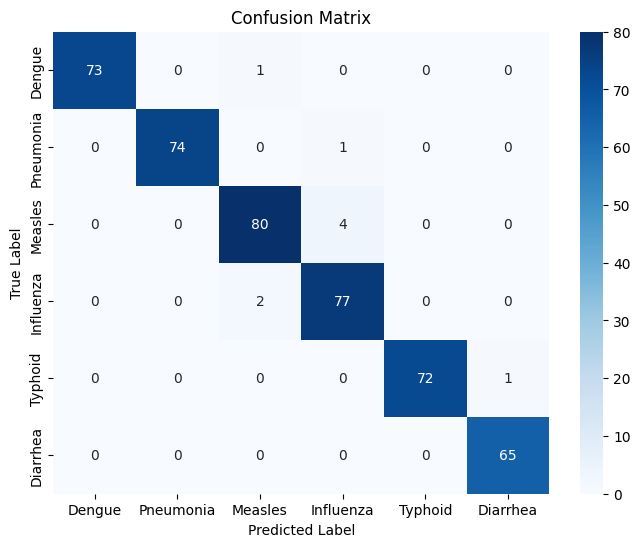

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predictions from the test set
test_split = tokenized_dataset["test"]
predictions, labels, _ = trainer.predict(test_split)
y_pred = np.argmax(predictions, axis=1)
y_true = np.array(labels)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels for the confusion matrix
labels = [id2label[i] for i in range(num_labels)]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.model_selection import StratifiedKFold
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import shutil
import os

# Define the number of folds
n_splits = 5
# Use StratifiedKFold to ensure balanced disease distribution in each fold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation results
all_accuracy_scores = []
all_classification_reports = []

# Convert the dataset to a pandas DataFrame for easier splitting
dataset_df = tokenized_dataset["train"].to_pandas()

# Get the labels for stratification
labels = dataset_df['labels']

for fold, (train_index, val_index) in enumerate(kf.split(dataset_df, labels)):
    folder_path = f"results_fold_{fold+1}"

    print("Removing previous cross val folder to save space...")

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Removed folder: {folder_path}")
    else:
        print(f"Folder not found: {folder_path}")

    print(f"--- Fold {fold+1}/{n_splits} ---")

    # Create train and validation datasets for the current fold
    train_dataset_fold = tokenized_dataset["train"].select(train_index)
    val_dataset_fold = tokenized_dataset["train"].select(val_index)

    # Re-initialize the model for each fold to ensure a fresh start
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        label2id=label2id,
        id2label=id2label,
        attention_dropout=0.1,
        mlp_dropout=0.1,
        embedding_dropout=0.1,
        classifier_dropout=0.1,
    )

    # Define training arguments for the current fold
    # Using the best hyperparameters found in the hyperparameter search
    training_args_fold = TrainingArguments(
        output_dir=f"./results_fold_{fold+1}",
        learning_rate=best_run.hyperparameters["learning_rate"],
        per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
        weight_decay=best_run.hyperparameters["weight_decay"],

        # Match final training configuration:
        num_train_epochs=8,  # Instead of 5
        warmup_steps=int((len(train_dataset_fold) // best_run.hyperparameters["per_device_train_batch_size"]) * 10 * 0.1),
        lr_scheduler_type="cosine",
        label_smoothing_factor=0.1,
        max_grad_norm=1.0,

        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        logging_strategy="epoch",
        report_to="none",
    )

    # Create Trainer for the current fold
    trainer_fold = Trainer(
        model=model,
        args=training_args_fold,
        train_dataset=train_dataset_fold,
        eval_dataset=val_dataset_fold,
        compute_metrics=lambda eval_pred: {"accuracy": (eval_pred.predictions.argmax(-1) == eval_pred.label_ids).mean()},
        data_collator=data_collator,
    )

    # Train the model for the current fold
    trainer_fold.train()

    # Evaluate the model on the validation data for the current fold
    predictions, labels, metrics = trainer_fold.predict(val_dataset_fold)
    y_pred_fold = np.argmax(predictions, axis=1)
    y_val_fold = np.array(labels)

    # Calculate and store accuracy and classification report
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    report_fold = classification_report(y_val_fold, y_pred_fold, target_names=[id2label[i] for i in range(num_labels)])

    all_accuracy_scores.append(accuracy_fold)
    all_classification_reports.append(report_fold)

    print(f"Accuracy for Fold {fold+1}: {accuracy_fold}")
    print(f"Classification Report for Fold {fold+1}:\n{report_fold}")

# Print average accuracy across all folds
print("\n--- Overall Results ---")
print(f"Average Accuracy across {n_splits} folds: {np.mean(all_accuracy_scores)}")

# Optionally, print classification reports for each fold
print("\n--- Classification Reports for Each Fold ---")
for fold, report in enumerate(all_classification_reports):
    print(f"Classification Report for Fold {fold+1}:\n{report}")

Removing previous cross val folder to save space...
Removed folder: results_fold_1
--- Fold 1/5 ---


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.274800,0.710402,0.900000
2,0.647800,0.550436,0.971429
3,0.505400,0.493078,0.973810
4,0.465700,0.474220,0.980952
5,0.442200,0.473224,0.980952
6,0.433900,0.463449,0.983333
7,0.428100,0.469275,0.983333
8,0.426600,0.470144,0.983333


Accuracy for Fold 1: 0.9833333333333333
Classification Report for Fold 1:
              precision    recall  f1-score   support

      Dengue       0.99      0.96      0.97        72
   Pneumonia       0.97      1.00      0.99        69
     Measles       1.00      0.97      0.99        70
   Influenza       0.96      1.00      0.98        69
     Typhoid       0.99      0.97      0.98        68
    Diarrhea       1.00      1.00      1.00        72

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420

Removing previous cross val folder to save space...
Folder not found: results_fold_2
--- Fold 2/5 ---


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.280500,0.700136,0.907143
2,0.611100,0.518162,0.973810
3,0.516400,0.512775,0.969048
4,0.461700,0.481947,0.976190
5,0.440800,0.480518,0.978571
6,0.434700,0.462153,0.983333
7,0.428400,0.456577,0.978571
8,0.426400,0.457717,0.978571


Accuracy for Fold 2: 0.9785714285714285
Classification Report for Fold 2:
              precision    recall  f1-score   support

      Dengue       1.00      1.00      1.00        71
   Pneumonia       0.97      1.00      0.99        69
     Measles       0.96      0.94      0.95        70
   Influenza       0.94      0.93      0.93        69
     Typhoid       1.00      1.00      1.00        68
    Diarrhea       1.00      1.00      1.00        73

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420

Removing previous cross val folder to save space...
Folder not found: results_fold_3
--- Fold 3/5 ---


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.288300,0.767451,0.902381
2,0.632700,0.591965,0.945238
3,0.521000,0.514823,0.959524
4,0.464500,0.496847,0.971429
5,0.441200,0.493576,0.969048
6,0.432200,0.494349,0.973810
7,0.426700,0.499144,0.969048
8,0.425800,0.498276,0.969048


Accuracy for Fold 3: 0.969047619047619
Classification Report for Fold 3:
              precision    recall  f1-score   support

      Dengue       0.97      0.99      0.98        71
   Pneumonia       1.00      1.00      1.00        68
     Measles       0.94      0.93      0.93        69
   Influenza       0.92      0.94      0.93        70
     Typhoid       1.00      0.96      0.98        69
    Diarrhea       0.99      1.00      0.99        73

    accuracy                           0.97       420
   macro avg       0.97      0.97      0.97       420
weighted avg       0.97      0.97      0.97       420

Removing previous cross val folder to save space...
Folder not found: results_fold_4
--- Fold 4/5 ---


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.326900,0.747959,0.892857
2,0.630400,0.583170,0.945238
3,0.509900,0.570674,0.950000
4,0.470300,0.482928,0.973810
5,0.445900,0.499552,0.971429
6,0.436300,0.482881,0.973810
7,0.430400,0.479705,0.976190
8,0.427500,0.480045,0.976190


Accuracy for Fold 4: 0.9761904761904762
Classification Report for Fold 4:
              precision    recall  f1-score   support

      Dengue       1.00      1.00      1.00        71
   Pneumonia       0.99      1.00      0.99        69
     Measles       0.94      0.94      0.94        69
   Influenza       0.94      0.94      0.94        70
     Typhoid       1.00      0.97      0.99        69
    Diarrhea       0.99      1.00      0.99        72

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420

Removing previous cross val folder to save space...
Folder not found: results_fold_5
--- Fold 5/5 ---


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at thomas-sounack/BioClinical-ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.258100,0.660634,0.942857
2,0.614400,0.541839,0.961905
3,0.497200,0.474358,0.980952
4,0.465900,0.477026,0.978571
5,0.448700,0.466717,0.978571
6,0.436300,0.466984,0.978571
7,0.430000,0.464140,0.983333
8,0.427400,0.464229,0.983333


Accuracy for Fold 5: 0.9833333333333333
Classification Report for Fold 5:
              precision    recall  f1-score   support

      Dengue       0.99      1.00      0.99        71
   Pneumonia       0.99      1.00      0.99        69
     Measles       0.96      0.97      0.96        69
   Influenza       0.97      0.94      0.96        70
     Typhoid       1.00      0.99      0.99        69
    Diarrhea       1.00      1.00      1.00        72

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420


--- Overall Results ---
Average Accuracy across 5 folds: 0.978095238095238

--- Classification Reports for Each Fold ---
Classification Report for Fold 1:
              precision    recall  f1-score   support

      Dengue       0.99      0.96      0.97        72
   Pneumonia       0.97      1.00      0.99        69
     Measles       1.00      0.97      0.99        70
   Influen

In [24]:
from transformers import pipeline

classifier = pipeline(
    task="text-classification",
    model="./final_model_train", # Use the fine-tuned model instead of model_id
    tokenizer=tokenizer, # Add the tokenizer
    device=0,
)

# Prompted from ChatGPT to simulate kunwari yung symptoms dedescribe niya ganon
dengue_sample ="I've been hit with a sudden, very high fever that came on a few days ago, and it's making me feel absolutely miserable. I have a throbbing headache that just won't quit, and my eyes hurt, especially behind them. My muscles and joints ache so intensely it feels like my bones are breaking. I'm utterly exhausted, sometimes feel nauseous, and have even thrown up once or twice. To top it all off, I've noticed a red, spotty rash spreading across my skin, and sometimes my gums bleed a little when I brush my teeth."
influenza_sample = "I woke up feeling like a truck hit me. It started with a sudden fever and chills, and now I'm aching all over my body – my muscles, my head, everywhere. I have a terrible dry cough that won't stop, and my throat is really sore. I feel so run down and tired that I can barely get out of bed, and I've completely lost my appetite. I'm also experiencing a lot of congestion and a runny nose, and sometimes I feel a bit dizzy."
typhoid_sample = "I've been dealing with a persistent and gradually worsening fever for about two weeks now, which has left me completely exhausted. It started subtle but has been getting higher each day. I have a constant headache, and my abdomen feels uncomfortably full and painful, sometimes I even get cramps. I'm either constipated or having mild diarrhea. I barely want to eat anything, and I've lost weight. I also feel a bit confused and just generally unwell, like I'm in a haze."
pneumonia_sample = "I've had a really bad cough for over a week now, and it's getting worse, bringing up a lot of thick, yellowish-green mucus. I keep getting high fevers accompanied by severe chills, and I'm sweating through my clothes, especially at night. It's become incredibly difficult to breathe, and I feel constantly short of breath, even when I'm just sitting still. Every time I try to cough or take a deep breath, I get a sharp, stabbing pain in my chest. I'm so weak and fatigued all the time, my appetite is gone, and lately, I've been feeling confused and lightheaded, which is really worrying me."
diarrhea_sample = "For the past day or two, I've had severe, watery diarrhea, and I'm having to run to the bathroom constantly. My stomach is cramping intensely, and I'm experiencing a lot of bloating and gas. I also feel quite nauseous and have vomited a few times. I'm starting to feel really weak and dizzy from losing so many fluids, and I have a dry mouth. I'm worried because the abdominal pain is quite severe, and I haven't been able to keep much food or water down."
measles_sample = "It started a few days ago with a fever, runny nose, sore throat, and a really irritating cough, almost like a bad cold. My eyes are red, watery, and very sensitive to light. Then, about a day or two ago, I noticed tiny white spots, like grains of salt, inside my mouth. Today, a red, blotchy rash appeared on my face, starting near my hairline, and it's now spreading down my neck and body. I feel really unwell and lethargic."

result_1 = classifier(dengue_sample)
result_2 = classifier(pneumonia_sample)
result_3 = classifier(typhoid_sample)
result_4 = classifier(influenza_sample)
result_5 = classifier(measles_sample)
result_6 = classifier(diarrhea_sample)

result_1, result_2, result_3, result_4, result_5, result_6

Device set to use cuda:0


([{'label': 'Dengue', 'score': 0.9025001525878906}],
 [{'label': 'Pneumonia', 'score': 0.9052286148071289}],
 [{'label': 'Typhoid', 'score': 0.7666863799095154}],
 [{'label': 'Influenza', 'score': 0.9198198318481445}],
 [{'label': 'Measles', 'score': 0.9243216514587402}],
 [{'label': 'Diarrhea', 'score': 0.9207943677902222}])

In [25]:
import shutil

# Download the model
shutil.make_archive("BioClinical_ModernBERT_base_Symptom2Disease_dataset_WITH-DROPOUT", 'zip', "final_model_train")

'/content/BioClinical_ModernBERT_base_Symptom2Disease_dataset_WITH-DROPOUT.zip'

# 🔬 Overfitting & Data Integrity Checks

High accuracy can signal either strong generalization or issues (data leakage, overlap, artifacts). This section validates correctness.

**Risks Investigated**
- Data leakage (same text in multiple splits)
- Memorization / overfitting
- Spurious artifacts (format, boilerplate)

**Checks**
1. Text overlap detection between train / validation / test.
2. Full test sweep: predicted vs expected labels (spot anomalies).
3. Qualitative inspection of difficult / long samples.

**Interpretation Guide**
- Zero / near‑zero overlap → split integrity OK.
- Consistently confident & correct predictions → likely real signal; verify class balance.
- If suspicious, consider: stratified splits, adding noise tests, or external validation set.

Outcome: Evidence that performance reflects genuine learning (or flags to address).

In [26]:
for row in dataset['test']:
  result = classifier(row['text'])

  print(f"Row text: {row['text']}")
  print(f"Expected: {id2label[row['labels']]}")
  print(f"Predicted: {result[0]['label']}\n")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Row text: Symptoms exploded within hours starting early yesterday with profound muscle aches and exhaustion. Dry cough keeping me awake, scratchy painful throat, fever measured at 102.6Â°F this afternoon, and body feels completely drained. Leg and shoulder muscles extremely sore. No runny nose paired with red eyes and cough simultaneously.
Expected: Measles
Predicted: Measles

Row text: It came on so suddenly while I was out shopping on Saturday. My temperature shot up to 102.8°F, and I was hit with such severe pain in my legs and back that I couldn't walk without help. I'm dealing with extreme fatigue, forcing me to rest every hour. A dry, hacking cough started up after the fever hit. Even in a heated car, I had violent chills. It also hurts a little to swallow because of a mild sore throat, and my frontal headache gets worse if I move my head. I had to leave my cart and get out of the store, which is crazy because just hours before I was feeling energetic and browsing with no problem

In [27]:
# Function to check for overlaps between two datasets
def check_overlap(dataset1, dataset2, split1_name, split2_name):
    set1 = set(dataset1['text'])
    set2 = set(dataset2['text'])
    overlap = set1.intersection(set2)
    if overlap:
        print(f"Overlap found between {split1_name} and {split2_name}: {len(overlap)} overlapping examples:")
        print(overlap)
    else:
        print(f"No overlap found between {split1_name} and {split2_name}.")

# Check for overlaps between the splits, mukhang isa lang naman yung naging overlap, the rest mukhang completely separate data na so parang ok naman yon i think
check_overlap(dataset['train'], dataset['validation'], 'train', 'validation')
check_overlap(dataset['train'], dataset['test'], 'train', 'test')
check_overlap(dataset['validation'], dataset['test'], 'validation', 'test')

No overlap found between train and validation.
No overlap found between train and test.
No overlap found between validation and test.


### Calibration Analysis

Text(0.5, 1.0, 'Confidence Distribution')

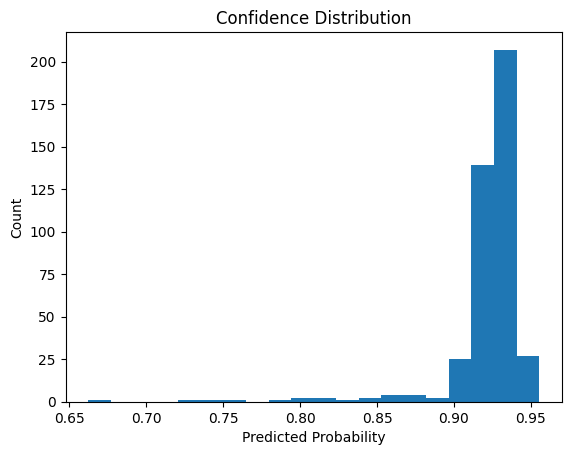

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import torch

# Get probability scores
probs = torch.softmax(torch.tensor(predictions), dim=-1).numpy()
max_probs = probs.max(axis=1)

# Plot reliability diagram
plt.hist(max_probs, bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Confidence Distribution')

### Error Analysis by Symptom Overlap

In [29]:
# Add after confusion matrix
import pandas as pd

# Find most common misclassifications
errors = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        errors.append({
            'true': id2label[y_true[i]],
            'predicted': id2label[y_pred[i]],
            'text': dataset['test'][i]['text']
        })

error_df = pd.DataFrame(errors)
print(error_df['true'].value_counts())
print("\nMost common confusions:")
print(error_df.groupby(['true', 'predicted']).size().sort_values(ascending=False).head(10))

true
Measles      4
Influenza    2
Pneumonia    1
Dengue       1
Typhoid      1
Name: count, dtype: int64

Most common confusions:
true       predicted
Measles    Influenza    4
Influenza  Measles      2
Dengue     Measles      1
Pneumonia  Influenza    1
Typhoid    Diarrhea     1
dtype: int64
